# Segmentação de Tumores Cerebrais - BraTS2020

## Pipeline de Pré-processamento para U-Net 3D

### Etapas do Pipeline:
1. **Carregamento e Organização dos Dados** - Estruturação do dataset
2. **Análise Exploratória** - Visualização e análise das modalidades  
3. **Normalização das Imagens** - Escala [0, 1]
4. **Remapeamento da Máscara** - Rótulos sequenciais (0,1,2,4 → 0,1,2,3)
5. **Combinação de Modalidades** - Volume multicanal
6. **Cropping Inteligente** - Foco na região de interesse
7. **Redimensionamento** - Tamanho fixo (128, 128, 64)
8. **DataLoader PyTorch** - Preparação para treinamento

### Dataset BraTS2020
- **Modalidades**: T1, T1ce, T2, FLAIR
- **Segmentação**: 4 classes (Fundo, NCR/NET, Edema, Tumor Realçante)
- **Formato**: NIfTI (.nii)

## Imports e Configurações

In [1]:
# Imports principais
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import os
import random
from sklearn.preprocessing import MinMaxScaler
from scipy.ndimage import zoom
from torch.utils.data import Dataset, DataLoader

In [2]:
# Configurações
TRAIN_DATASET_PATH = 'BraTS2020_TrainingData'
VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData'
TARGET_SIZE = (128, 128, 64)
CROP_MARGIN = 10

# Seed para reprodutibilidade
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

## Organização dos Dados

In [12]:
import glob

def organize_patients_from_folders(data_dir):
    """Organiza pacientes de forma simples e direta"""
    patients = {}
    
    # Buscar todas as pastas BraTS20
    pattern = os.path.join(data_dir, "**", "BraTS20*")
    patient_dirs = glob.glob(pattern, recursive=True)
    
    for patient_path in patient_dirs:
        if os.path.isdir(patient_path):
            patient_id = os.path.basename(patient_path)
            patients[patient_id] = {}
            
            # Buscar arquivos .nii na pasta do paciente
            for file in os.listdir(patient_path):
                if file.endswith('.nii'):
                    file_path = os.path.join(patient_path, file)
                    file_lower = file.lower()
                    
                    if 'flair' in file_lower:
                        patients[patient_id]['flair'] = file_path
                    elif 't1ce' in file_lower:
                        patients[patient_id]['t1ce'] = file_path
                    elif 't1' in file_lower and 't1ce' not in file_lower:
                        patients[patient_id]['t1'] = file_path
                    elif 't2' in file_lower:
                        patients[patient_id]['t2'] = file_path
                    elif 'seg' in file_lower:
                        patients[patient_id]['seg'] = file_path
    
    return patients

def organize_all_patients():
    """Organiza todos os pacientes"""
    train_patients_data = organize_patients_from_folders(TRAIN_DATASET_PATH)
    val_patients_data = organize_patients_from_folders(VALIDATION_DATASET_PATH)
    all_patients_data = {**train_patients_data, **val_patients_data}
    
    return all_patients_data, train_patients_data, val_patients_data

def create_splits(train_patients_data, val_patients_data):
    """Criar divisões treino/validação/teste"""
    training_patients = list(train_patients_data.keys())
    validation_patients = list(val_patients_data.keys())
    
    if validation_patients:
        random.shuffle(training_patients)
        split_idx = int(0.7 * len(training_patients))
        
        train_set = training_patients[:split_idx]
        val_set = training_patients[split_idx:]
        test_set = validation_patients
    else:
        random.shuffle(training_patients)
        train_size = int(0.7 * len(training_patients))
        val_size = int(0.15 * len(training_patients))
        
        train_set = training_patients[:train_size]
        val_set = training_patients[train_size:train_size + val_size]
        test_set = training_patients[train_size + val_size:]
    
    return train_set, val_set, test_set

In [13]:
# Executar organização dos dados
all_patients_data, train_patients_data, val_patients_data = organize_all_patients()
train_patients, val_patients, test_patients = create_splits(train_patients_data, val_patients_data)

print(f"Pacientes - Treino: {len(train_patients_data)}, Validação: {len(val_patients_data)}")
print(f"Divisões - Treino: {len(train_patients)}, Validação: {len(val_patients)}, Teste: {len(test_patients)}")

# Mostrar exemplo de paciente
if train_patients_data:
    first_patient = list(train_patients_data.keys())[0]
    print(f"Exemplo: {first_patient}")
    for modality in train_patients_data[first_patient].keys():
        print(f"  {modality}: ✓")

Pacientes - Treino: 369, Validação: 125
Divisões - Treino: 258, Validação: 111, Teste: 125
Exemplo: BraTS20_Training_001
  flair: ✓
  seg: ✓
  t1: ✓
  t1ce: ✓
  t2: ✓


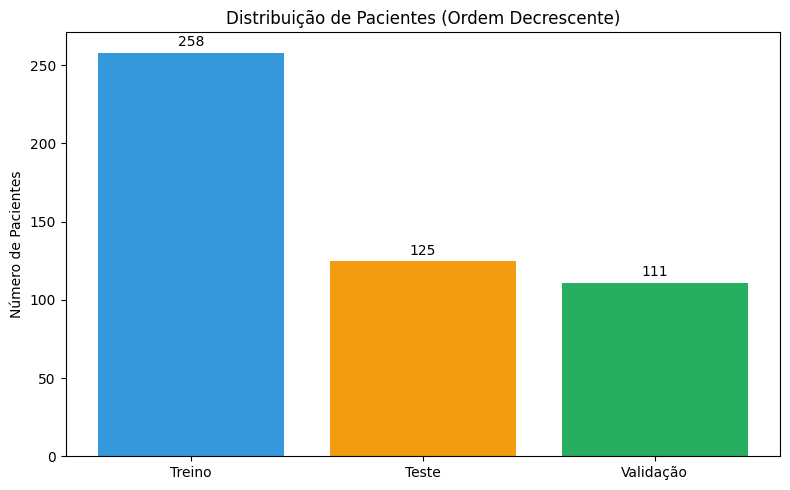

In [14]:
# Visualizar distribuição em ordem decrescente
data = [
    ('Treino', len(train_patients)),
    ('Validação', len(val_patients)),
    ('Teste', len(test_patients))
]

# Ordenar por contagem em ordem decrescente
data_sorted = sorted(data, key=lambda x: x[1], reverse=True)
labels = [item[0] for item in data_sorted]
counts = [item[1] for item in data_sorted]

plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts, color=['#3498db', '#f39c12', '#27ae60'])
plt.title('Distribuição de Pacientes (Ordem Decrescente)')
plt.ylabel('Número de Pacientes')

for i, count in enumerate(counts):
    plt.text(i, count + 2, str(count), ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Funções Utilitárias

### Pré-processamento e Transformações
- Normalização Min-Max
- Remapeamento de rótulos 
- Combinação de modalidades
- Cropping inteligente
- Redimensionamento

## Análise Exploratória das Modalidades

### Funções de Análise
- Análise de modalidades brutas
- Análise de contraste para seleção automática
- Visualização comparativa

In [ ]:
def analyze_raw_modalities(patient_files):
    """Analisa modalidades brutas antes da normalização"""
    modalities = ['t1', 't1ce', 't2', 'flair']
    raw_data = {}
    
    for modality in modalities:
        if modality in patient_files:
            data = nib.load(patient_files[modality]).get_fdata()
            raw_data[modality] = data
            
            print(f"\n{modality.upper()}:")
            print(f"   Shape: {data.shape}")
            print(f"   Min: {data.min():.2f}")
            print(f"   Max: {data.max():.2f}")
            print(f"   Mean: {data.mean():.2f}")
            print(f"   Std: {data.std():.2f}")
            print(f"   Valores únicos: {len(np.unique(data))}")
    
    return raw_data

def visualize_raw_modalities(raw_data, mask_data, slice_idx=None):
    """Visualiza modalidades brutas com máscara"""
    modalities = list(raw_data.keys())
    n_modalities = len(modalities)
    
    if slice_idx is None:
        slice_idx = raw_data[modalities[0]].shape[2] // 2
    
    fig, axes = plt.subplots(2, n_modalities, figsize=(20, 8))
    
    # Primeira linha: modalidades brutas
    for i, modality in enumerate(modalities):
        data = raw_data[modality]
        axes[0, i].imshow(data[:, :, slice_idx], cmap='gray')
        axes[0, i].set_title(f'{modality.upper()} - Bruto')
        axes[0, i].axis('off')
    
    # Segunda linha: modalidades com overlay da máscara
    for i, modality in enumerate(modalities):
        data = raw_data[modality]
        axes[1, i].imshow(data[:, :, slice_idx], cmap='gray')
        
        # Overlay da máscara
        mask_slice = mask_data[:, :, slice_idx]
        masked_overlay = np.ma.masked_where(mask_slice == 0, mask_slice)
        axes[1, i].imshow(masked_overlay, cmap='viridis', alpha=0.3)
        axes[1, i].set_title(f'{modality.upper()} + Máscara')
        axes[1, i].axis('off')
    
    plt.suptitle(f'Modalidades Brutas - Fatia {slice_idx}')
    plt.tight_layout()
    plt.show()

def analyze_mask_labels(mask_data):
    """Analisa os rótulos da máscara original"""
    unique_labels = np.unique(mask_data)
    
    print(f"\nANÁLISE DA MÁSCARA:")
    print(f"   Rótulos únicos: {unique_labels}")
    print(f"   Distribuição:")
    
    for label in unique_labels:
        count = np.sum(mask_data == label)
        percentage = (count / mask_data.size) * 100
        
        label_name = {
            0: "Fundo",
            1: "NCR/NET (Necrose)",
            2: "Edema",
            4: "Tumor Realçante"
        }.get(label, f"Desconhecido ({label})")
        
        print(f"     {label}: {label_name} - {count:,} voxels ({percentage:.2f}%)")
    
    return unique_labels

In [ ]:
def analyze_contrast_tumor_separation(raw_data, mask_data):
    """Analisa contraste entre modalidades para separação de tumor"""
    modalities = list(raw_data.keys())
    contrast_scores = {}
    
    print(f"\nANÁLISE DE CONTRASTE PARA SEPARAÇÃO DE TUMOR:")
    print("=" * 50)
    
    for modality in modalities:
        data = raw_data[modality]
        
        # Extrair intensidades para diferentes regiões
        background = data[mask_data == 0]  # Fundo
        tumor_core = data[mask_data == 1]  # NCR/NET
        edema = data[mask_data == 2]       # Edema
        enhancing = data[mask_data == 4]   # Tumor realçante
        
        # Calcular médias das regiões
        bg_mean = background.mean() if len(background) > 0 else 0
        tumor_mean = tumor_core.mean() if len(tumor_core) > 0 else 0
        edema_mean = edema.mean() if len(edema) > 0 else 0
        enh_mean = enhancing.mean() if len(enhancing) > 0 else 0
        
        # Calcular contrastes (diferenças normalizadas)
        contrast_tumor_bg = abs(tumor_mean - bg_mean) / (tumor_mean + bg_mean + 1e-8)
        contrast_enh_bg = abs(enh_mean - bg_mean) / (enh_mean + bg_mean + 1e-8)
        contrast_edema_bg = abs(edema_mean - bg_mean) / (edema_mean + bg_mean + 1e-8)
        
        # Score geral (média ponderada dos contrastes)
        overall_contrast = (contrast_tumor_bg + contrast_enh_bg + contrast_edema_bg) / 3
        
        contrast_scores[modality] = {
            'overall': overall_contrast,
            'tumor_bg': contrast_tumor_bg,
            'enhancing_bg': contrast_enh_bg,
            'edema_bg': contrast_edema_bg,
            'means': {
                'background': bg_mean,
                'tumor_core': tumor_mean,
                'edema': edema_mean,
                'enhancing': enh_mean
            }
        }
        
        print(f"\n{modality.upper()}:")
        print(f"   Médias por região:")
        print(f"     Fundo: {bg_mean:.2f}")
        print(f"     Tumor Core: {tumor_mean:.2f}")
        print(f"     Edema: {edema_mean:.2f}")
        print(f"     Realçante: {enh_mean:.2f}")
        print(f"   Contrastes:")
        print(f"     Tumor-Fundo: {contrast_tumor_bg:.3f}")
        print(f"     Realçante-Fundo: {contrast_enh_bg:.3f}")
        print(f"     Edema-Fundo: {contrast_edema_bg:.3f}")
        print(f"   Score Geral: {overall_contrast:.3f}")
    
    return contrast_scores

def select_best_modalities(contrast_scores, n_best=3):
    """Seleciona as melhores modalidades baseado no contraste"""
    # Ordenar por score geral em ordem decrescente
    sorted_modalities = sorted(contrast_scores.items(), 
                              key=lambda x: x[1]['overall'], 
                              reverse=True)
    
    best_modalities = [mod[0] for mod in sorted_modalities[:n_best]]
    
    print(f"\nRANKING DE MODALIDADES (por contraste):")
    print("=" * 40)
    for i, (modality, scores) in enumerate(sorted_modalities, 1):
        status = "SELECIONADA" if modality in best_modalities else "Não selecionada"
        print(f"{i}. {modality.upper()}: {scores['overall']:.3f} - {status}")
    
    print(f"\nMODALIDADES SELECIONADAS: {[mod.upper() for mod in best_modalities]}")
    return best_modalities

def visualize_contrast_comparison(raw_data, mask_data, slice_idx=None):
    """Visualiza comparação de contraste entre modalidades"""
    modalities = list(raw_data.keys())
    
    if slice_idx is None:
        slice_idx = raw_data[modalities[0]].shape[2] // 2
    
    fig, axes = plt.subplots(2, len(modalities), figsize=(20, 8))
    
    for i, modality in enumerate(modalities):
        data = raw_data[modality]
        
        # Imagem original
        axes[0, i].imshow(data[:, :, slice_idx], cmap='gray')
        axes[0, i].set_title(f'{modality.upper()} - Original')
        axes[0, i].axis('off')
        
        # Imagem com realce nas regiões de tumor
        tumor_regions = (mask_data[:, :, slice_idx] > 0)
        enhanced_data = data[:, :, slice_idx].copy()
        enhanced_data[tumor_regions] = enhanced_data[tumor_regions] * 1.5  # Realçar tumor
        
        axes[1, i].imshow(enhanced_data, cmap='hot')
        axes[1, i].set_title(f'{modality.upper()} - Tumor Realçado')
        axes[1, i].axis('off')
    
    plt.suptitle(f'Comparação de Contraste - Fatia {slice_idx}')
    plt.tight_layout()
    plt.show()

ANÁLISE DAS MODALIDADES BRUTAS - PACIENTE: BraTS20_Training_001

📊 T1:
   Shape: (240, 240, 155)
   Min: 0.00
   Max: 678.00
   Mean: 53.29
   Std: 130.78
   Valores únicos: 573

📊 T1CE:
   Shape: (240, 240, 155)
   Min: 0.00
   Max: 1845.00
   Mean: 62.77
   Std: 155.08
   Valores únicos: 573

📊 T1CE:
   Shape: (240, 240, 155)
   Min: 0.00
   Max: 1845.00
   Mean: 62.77
   Std: 155.08
   Valores únicos: 1501

📊 T2:
   Shape: (240, 240, 155)
   Min: 0.00
   Max: 376.00
   Mean: 17.25
   Std: 44.98
   Valores únicos: 1501

📊 T2:
   Shape: (240, 240, 155)
   Min: 0.00
   Max: 376.00
   Mean: 17.25
   Std: 44.98
   Valores únicos: 359

📊 FLAIR:
   Shape: (240, 240, 155)
   Min: 0.00
   Max: 625.00
   Mean: 26.02
   Std: 66.77
   Valores únicos: 359

📊 FLAIR:
   Shape: (240, 240, 155)
   Min: 0.00
   Max: 625.00
   Mean: 26.02
   Std: 66.77
   Valores únicos: 452

🏷️  ANÁLISE DA MÁSCARA:
   Rótulos únicos: [0. 1. 2. 4.]
   Distribuição:
     0.0: Fundo - 8,716,021 voxels (97.63%)
   Valore

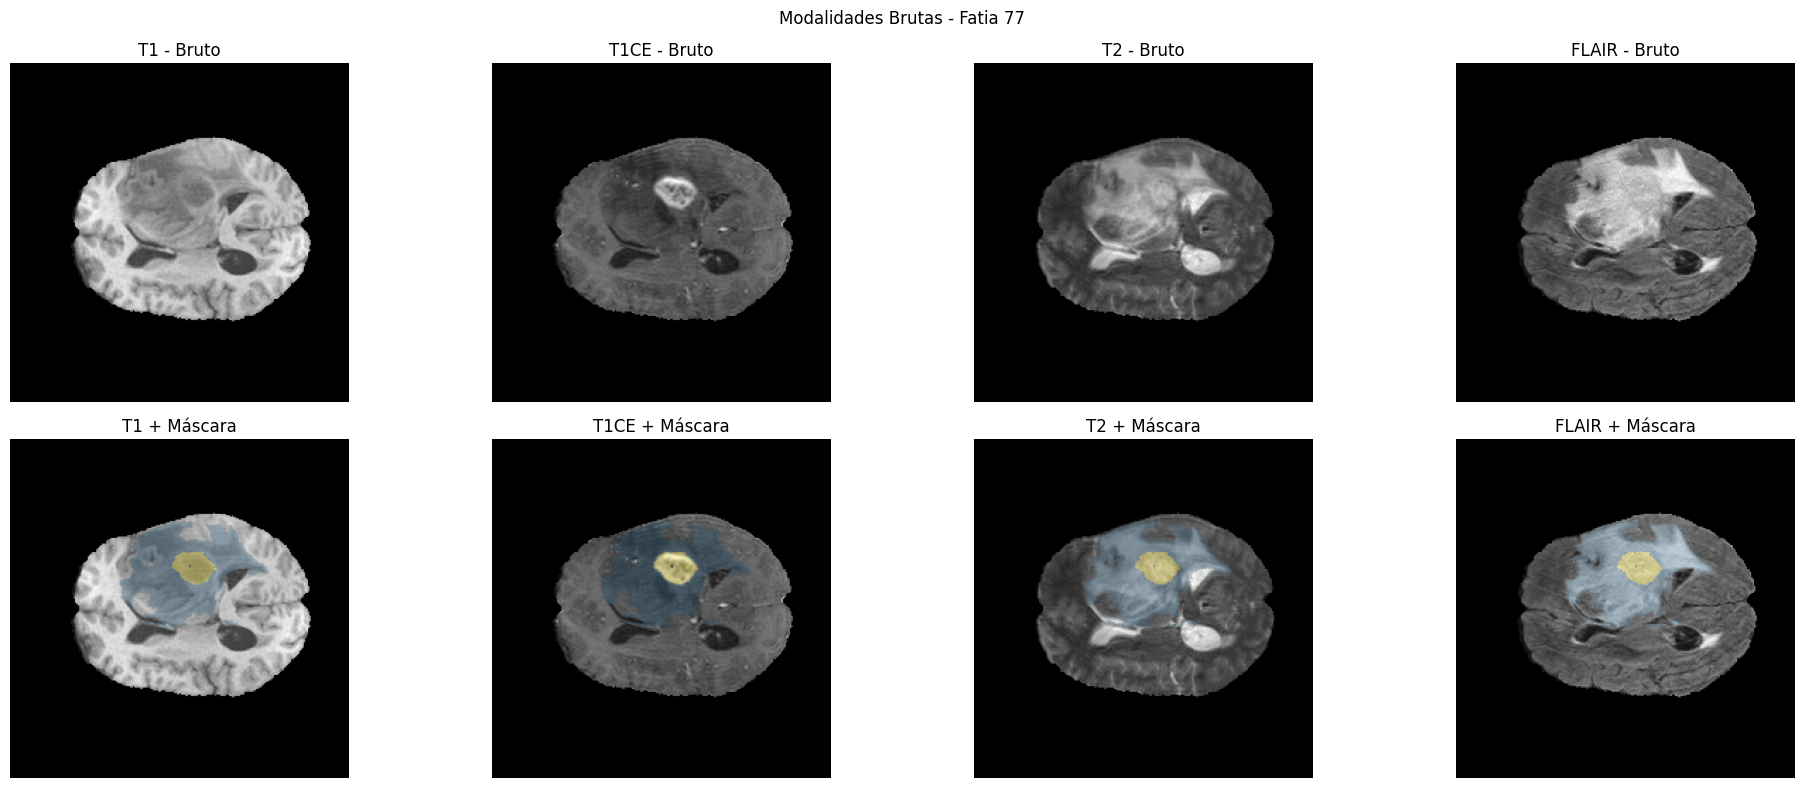

In [42]:
# Análise das Modalidades Brutas
first_patient = list(train_patients_data.keys())[0]
patient_files = train_patients_data[first_patient]

print(f"ANÁLISE DAS MODALIDADES BRUTAS - PACIENTE: {first_patient}")
print("=" * 60)

# Analisar modalidades brutas
raw_data = analyze_raw_modalities(patient_files)

# Carregar e analisar máscara
if 'seg' in patient_files:
    mask_data = nib.load(patient_files['seg']).get_fdata()
    unique_labels = analyze_mask_labels(mask_data)
    
    # Visualizar modalidades brutas
    print("\nVISUALIZAÇÃO DAS MODALIDADES BRUTAS:")
    visualize_raw_modalities(raw_data, mask_data)
    
else:
    print("Máscara não disponível para análise")
    mask_data = None

ANÁLISE DE CONTRASTE PARA SEPARAÇÃO DE TUMOR

🔬 ANÁLISE DE CONTRASTE PARA SEPARAÇÃO DE TUMOR:

📈 T1:
   Médias por região:
     Fundo: 47.22
     Tumor Core: 206.68
     Edema: 320.44
     Realçante: 249.99
   Contrastes:
     Tumor-Fundo: 0.628
     Realçante-Fundo: 0.682
     Edema-Fundo: 0.743
   📊 Score Geral: 0.684

📈 T1CE:
   Médias por região:
     Fundo: 54.68
     Tumor Core: 306.28
     Edema: 355.94
     Realçante: 685.31
   Contrastes:
     Tumor-Fundo: 0.697
     Realçante-Fundo: 0.852
     Edema-Fundo: 0.734
   📊 Score Geral: 0.761

📈 T2:
   Médias por região:
     Fundo: 13.41
     Tumor Core: 228.70
     Edema: 165.56
     Realçante: 202.96
   Contrastes:
     Tumor-Fundo: 0.889
     Realçante-Fundo: 0.876
     Edema-Fundo: 0.850
   📊 Score Geral: 0.872

📈 T1CE:
   Médias por região:
     Fundo: 54.68
     Tumor Core: 306.28
     Edema: 355.94
     Realçante: 685.31
   Contrastes:
     Tumor-Fundo: 0.697
     Realçante-Fundo: 0.852
     Edema-Fundo: 0.734
   📊 Score Ger

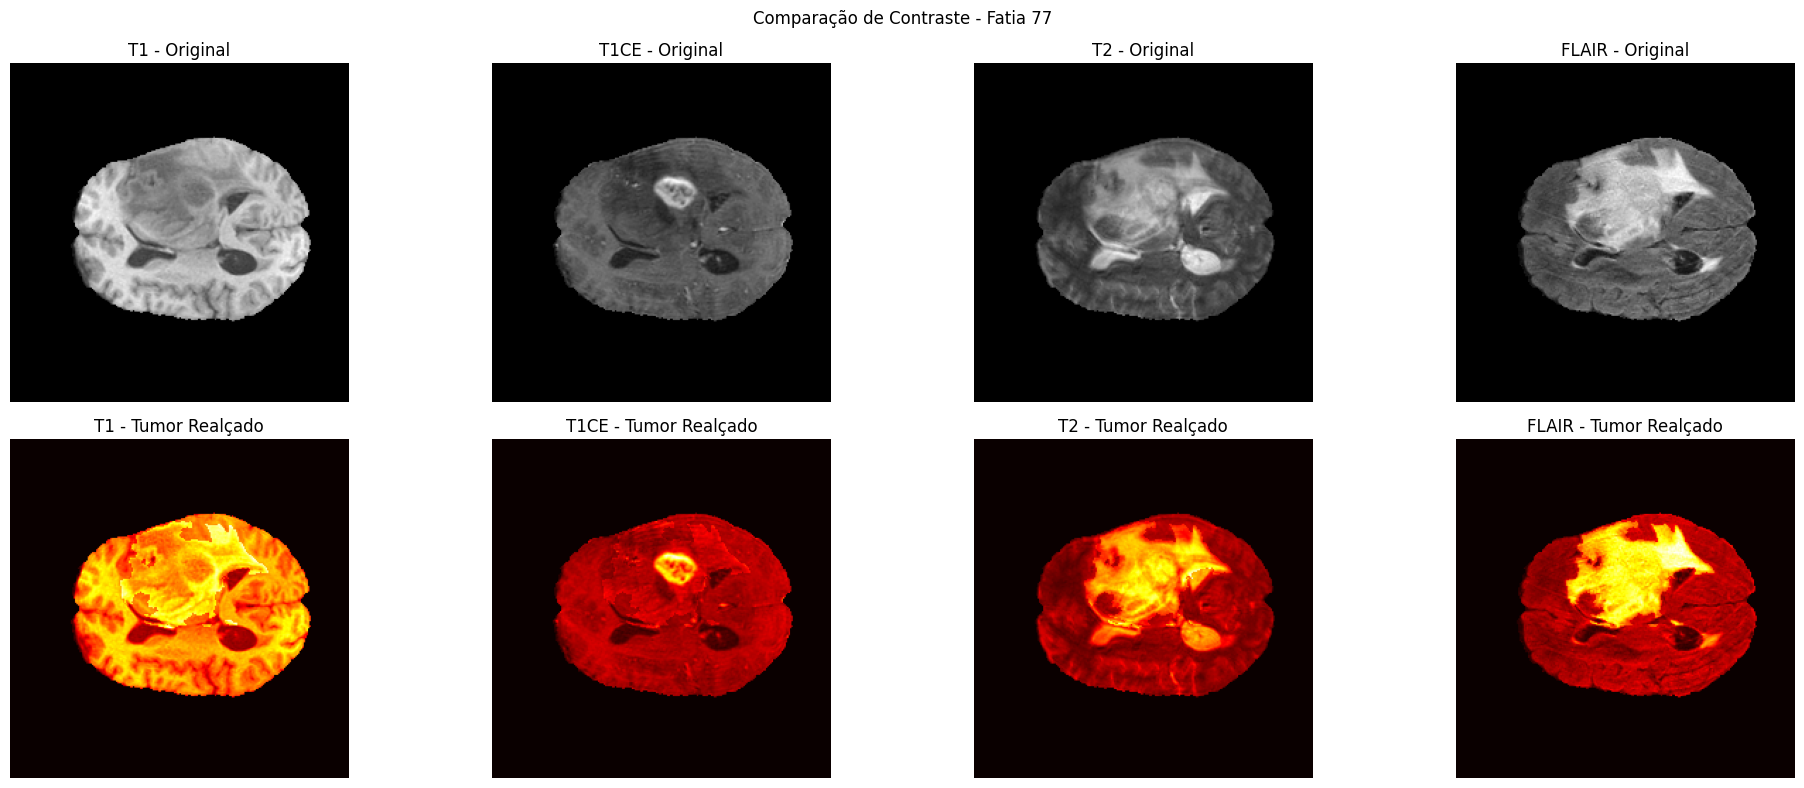

In [43]:
# Análise de Contraste e Seleção de Modalidades
if mask_data is not None:
    print("ANÁLISE DE CONTRASTE PARA SEPARAÇÃO DE TUMOR")
    print("=" * 60)
    
    # Análise de contraste
    contrast_scores = analyze_contrast_tumor_separation(raw_data, mask_data)
    
    # Seleção das melhores modalidades
    print("\nSELEÇÃO DAS MELHORES MODALIDADES:")
    best_modalities = select_best_modalities(contrast_scores, n_best=3)
    
    # Visualização da comparação de contraste
    print("\nCOMPARAÇÃO VISUAL DE CONTRASTE:")
    visualize_contrast_comparison(raw_data, mask_data)
    
else:
    print("Máscara não disponível para análise de contraste")
    best_modalities = ['t1', 't1ce', 't2']  # Fallback

In [45]:
def apply_minmax_scaler(image_data):
    """Aplica Min-Max scaling em uma imagem 3D"""
    original_shape = image_data.shape
    image_flat = image_data.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    image_scaled = scaler.fit_transform(image_flat)
    return image_scaled.reshape(original_shape)

def remap_labels(mask_data):
    """Reatribui rótulos para serem contínuos: 0,1,2,4 -> 0,1,2,3"""
    mask_remapped = mask_data.copy()
    mask_remapped[mask_data == 4] = 3
    return mask_remapped

def combine_modalities(patient_files, selected_modalities=None):
    """Combina modalidades selecionadas em um volume multicanal"""
    if selected_modalities is None:
        selected_modalities = ['t1', 't1ce', 't2']  # Default: 3 modalidades
    
    combined_channels = []
    
    for modality in selected_modalities:
        if modality in patient_files:
            data = nib.load(patient_files[modality]).get_fdata()
            data_normalized = apply_minmax_scaler(data)
            combined_channels.append(data_normalized)
    
    if combined_channels:
        combined_volume = np.stack(combined_channels, axis=-1)
        return combined_volume
    return None

def find_bounding_box(mask, margin=10):
    """Encontra bounding box baseado na máscara"""
    coords = np.where(mask > 0)
    
    if len(coords[0]) == 0:
        # Fallback: usar crop central se não há máscara
        h, w, d = mask.shape
        return (h//4, 3*h//4, w//4, 3*w//4, d//4, 3*d//4)
    
    x_min, x_max = coords[0].min(), coords[0].max()
    y_min, y_max = coords[1].min(), coords[1].max()
    z_min, z_max = coords[2].min(), coords[2].max()
    
    # Aplicar margem com proteção de bounds
    x_min = max(0, x_min - margin)
    x_max = min(mask.shape[0], x_max + margin)
    y_min = max(0, y_min - margin)
    y_max = min(mask.shape[1], y_max + margin)
    z_min = max(0, z_min - margin)
    z_max = min(mask.shape[2], z_max + margin)
    
    return x_min, x_max, y_min, y_max, z_min, z_max

def intelligent_crop_volume(volume, mask=None, target_size=TARGET_SIZE, margin=CROP_MARGIN):
    """Aplica cropping inteligente com proteção para casos sem máscara"""
    
    if mask is None:
        # Sem máscara: usar crop central
        h, w, d = volume.shape[:3]
        x_min, x_max = h//4, 3*h//4
        y_min, y_max = w//4, 3*w//4
        z_min, z_max = d//4, 3*d//4
        mask_cropped = None
    else:
        # Com máscara: usar bounding box
        x_min, x_max, y_min, y_max, z_min, z_max = find_bounding_box(mask, margin)
        mask_cropped = mask[x_min:x_max, y_min:y_max, z_min:z_max]
    
    # Aplicar crop no volume
    if len(volume.shape) == 4:
        volume_cropped = volume[x_min:x_max, y_min:y_max, z_min:z_max, :]
    else:
        volume_cropped = volume[x_min:x_max, y_min:y_max, z_min:z_max]
    
    # Redimensionar para tamanho alvo
    current_shape = volume_cropped.shape[:3]
    zoom_factors = [target_size[i] / current_shape[i] for i in range(3)]
    
    if len(volume_cropped.shape) == 4:
        # Volume multicanal
        volume_resized = np.zeros((*target_size, volume_cropped.shape[3]))
        for channel in range(volume_cropped.shape[3]):
            volume_resized[:, :, :, channel] = zoom(
                volume_cropped[:, :, :, channel], zoom_factors, order=1, mode='constant'
            )
    else:
        # Volume single channel
        volume_resized = zoom(volume_cropped, zoom_factors, order=1, mode='constant')
    
    # Redimensionar máscara se existir
    if mask_cropped is not None:
        mask_resized = zoom(mask_cropped, zoom_factors, order=0, mode='constant')
    else:
        mask_resized = None
    
    return volume_resized, mask_resized

def visualize_crop_region(volume, mask, margin=10, slice_idx=None):
    """Visualiza a região de crop com bounding box destacado"""
    
    # Encontrar bounding box
    if mask is not None:
        x_min, x_max, y_min, y_max, z_min, z_max = find_bounding_box(mask, margin)
    else:
        # Fallback: usar crop central
        h, w, d = volume.shape[:3]
        x_min, x_max = h//4, 3*h//4
        y_min, y_max = w//4, 3*w//4
        z_min, z_max = d//4, 3*d//4
    
    # Selecionar fatia para visualização
    if slice_idx is None:
        slice_idx = (z_min + z_max) // 2  # Meio da região de interesse
    
    # Preparar dados para visualização
    if len(volume.shape) == 4:
        # Volume multicanal - usar primeira modalidade
        volume_slice = volume[:, :, slice_idx, 0]
    else:
        volume_slice = volume[:, :, slice_idx]
    
    mask_slice = mask[:, :, slice_idx] if mask is not None else None
    
    # Criar visualização
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Imagem original
    axes[0].imshow(volume_slice, cmap='gray')
    axes[0].set_title('Volume Original')
    axes[0].axis('off')
    
    # 2. Imagem com bounding box destacado
    axes[1].imshow(volume_slice, cmap='gray')
    
    # Desenhar retângulo do bounding box
    from matplotlib.patches import Rectangle
    rect = Rectangle((y_min, x_min), y_max - y_min, x_max - x_min, 
                    linewidth=2, edgecolor='red', facecolor='none')
    axes[1].add_patch(rect)
    
    # Adicionar texto com dimensões
    bbox_text = f'Bounding Box:\n({x_min},{y_min}) → ({x_max},{y_max})\nTamanho: {x_max-x_min}×{y_max-y_min}'
    axes[1].text(0.02, 0.98, bbox_text, transform=axes[1].transAxes, 
                fontsize=10, verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    axes[1].set_title('Volume com Bounding Box')
    axes[1].axis('off')
    
    # 3. Região cropada
    if len(volume.shape) == 4:
        cropped_region = volume[x_min:x_max, y_min:y_max, slice_idx, 0]
    else:
        cropped_region = volume[x_min:x_max, y_min:y_max, slice_idx]
    
    axes[2].imshow(cropped_region, cmap='gray')
    axes[2].set_title('Região Cropada')
    axes[2].axis('off')
    
    # Overlay da máscara na região cropada se disponível
    if mask_slice is not None:
        mask_cropped = mask_slice[x_min:x_max, y_min:y_max]
        masked_overlay = np.ma.masked_where(mask_cropped == 0, mask_cropped)
        axes[2].imshow(masked_overlay, cmap='viridis', alpha=0.3)
    
    plt.suptitle(f'Processo de Cropping - Fatia {slice_idx}')
    plt.tight_layout()
    plt.show()
    
    # Mostrar informações detalhadas
    print(f"\nINFORMAÇÕES DO CROPPING:")
    print(f"   Volume original: {volume.shape}")
    print(f"   Bounding box: ({x_min},{y_min},{z_min}) → ({x_max},{y_max},{z_max})")
    print(f"   Dimensões do crop: {x_max-x_min} × {y_max-y_min} × {z_max-z_min}")
    print(f"   Margem aplicada: {margin} pixels")
    print(f"   Fatia visualizada: {slice_idx}")
    
    if mask is not None:
        tumor_voxels = np.sum(mask > 0)
        total_voxels = mask.size
        tumor_percentage = (tumor_voxels / total_voxels) * 100
        print(f"   Voxels com tumor: {tumor_voxels:,} ({tumor_percentage:.2f}%)")

TESTE DO PIPELINE COM MODALIDADES SELECIONADAS
Paciente: BraTS20_Training_001
Modalidades: ['T2', 'FLAIR', 'T1CE']
--------------------------------------------------
Volume combinado: (240, 240, 155, 3)
Máscara remapeada: (240, 240, 155)

VISUALIZAÇÃO DO PROCESSO DE CROPPING:
Volume combinado: (240, 240, 155, 3)
Máscara remapeada: (240, 240, 155)

VISUALIZAÇÃO DO PROCESSO DE CROPPING:


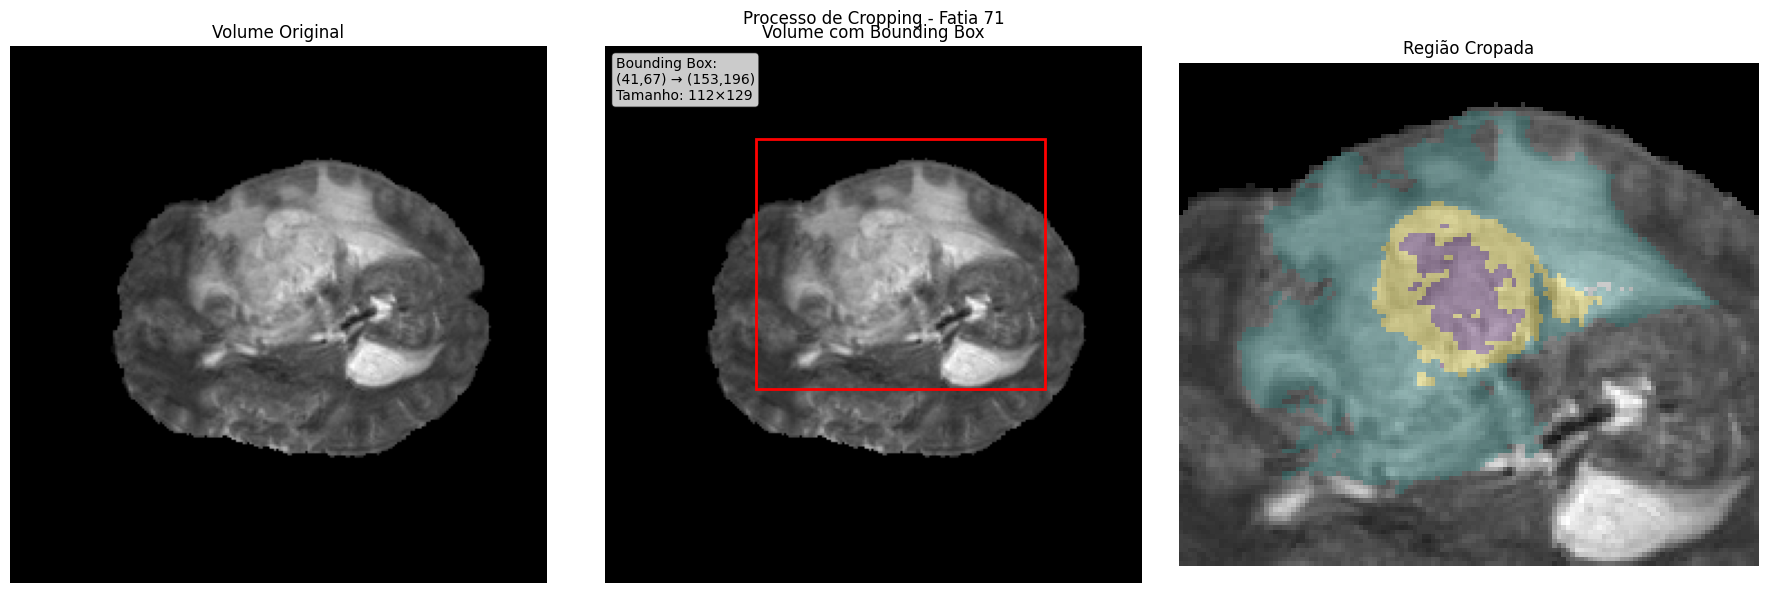


INFORMAÇÕES DO CROPPING:
   Volume original: (240, 240, 155, 3)
   Bounding box: (41,67,20) → (153,196,122)
   Dimensões do crop: 112 × 129 × 102
   Margem aplicada: 10 pixels
   Fatia visualizada: 71
   Voxels com tumor: 211,979 (2.37%)

Volume final: (128, 128, 64, 3)
Máscara final: (128, 128, 64)
Rótulos únicos: [0. 1. 2. 3.]
Rótulos únicos: [0. 1. 2. 3.]


In [46]:
# Teste do Pipeline com Modalidades Selecionadas
print("TESTE DO PIPELINE COM MODALIDADES SELECIONADAS")
print(f"Paciente: {first_patient}")
print(f"Modalidades: {[mod.upper() for mod in best_modalities]}")
print("-" * 50)

# Processar dados com modalidades selecionadas
combined_volume = combine_modalities(patient_files, best_modalities)
mask = None
if 'seg' in patient_files:
    mask = nib.load(patient_files['seg']).get_fdata()
    mask = remap_labels(mask)

print(f"Volume combinado: {combined_volume.shape if combined_volume is not None else 'N/A'}")
print(f"Máscara remapeada: {mask.shape if mask is not None else 'N/A'}")

# Visualizar processo de cropping
if combined_volume is not None:
    print("\nVISUALIZAÇÃO DO PROCESSO DE CROPPING:")
    visualize_crop_region(combined_volume, mask, CROP_MARGIN)
    
    # Aplicar cropping inteligente
    volume_final, mask_final = intelligent_crop_volume(combined_volume, mask)
    print(f"\nVolume final: {volume_final.shape}")
    print(f"Máscara final: {mask_final.shape if mask_final is not None else 'N/A'}")
    
    # Verificar rótulos finais
    if mask_final is not None:
        unique_labels = np.unique(mask_final)
        print(f"Rótulos únicos: {unique_labels}")
else:
    print("Erro: Volume combinado não pôde ser criado")

### Visualização do Processo de Cropping

A função `visualize_crop_region()` exibe:
- **Volume Original**: Imagem completa antes do processamento
- **Bounding Box**: Região detectada automaticamente baseada na máscara
- **Região Cropada**: Área final após o cropping com overlay da máscara

**Características:**
- Bounding Box calculado automaticamente com margem de segurança
- Cropping inteligente focado na região de interesse
- Informações detalhadas sobre dimensões e estatísticas

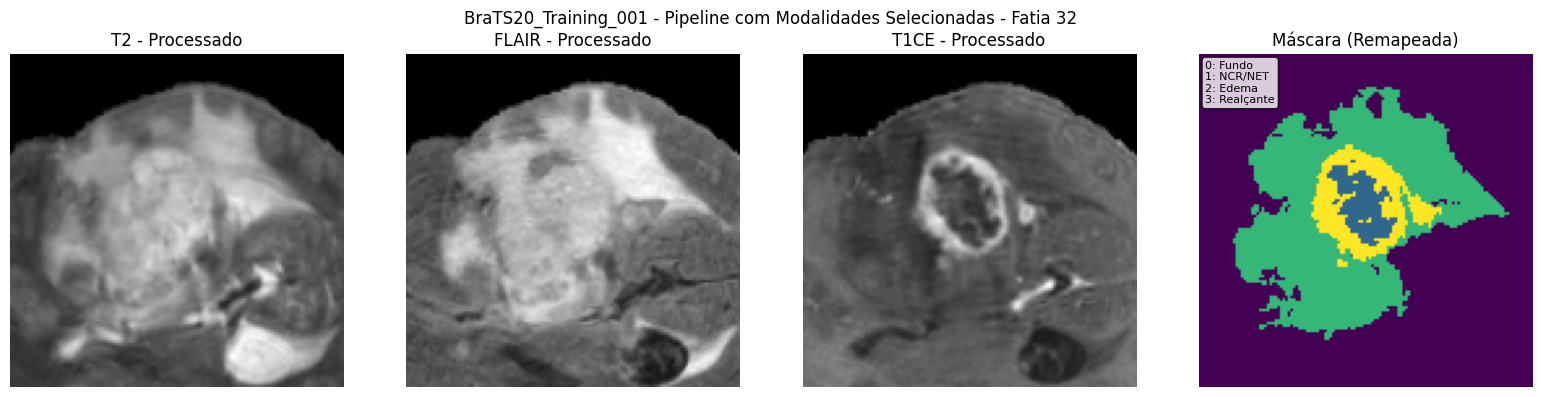


📊 ESTATÍSTICAS FINAIS:
Volume processado: (128, 128, 64, 3)
Modalidades utilizadas: ['T2', 'FLAIR', 'T1CE']
Range de valores por modalidade:
  T2: [0.000, 0.961]
  FLAIR: [0.000, 0.839]
  T1CE: [0.000, 0.785]
Máscara: (128, 128, 64)
Distribuição de rótulos:
  0 (Fundo): 900,290 voxels (85.86%)
  1 (NCR/NET): 10,522 voxels (1.00%)
  2 (Edema): 118,471 voxels (11.30%)
  3 (Realçante): 19,293 voxels (1.84%)


In [ ]:
# Visualização do Resultado Final
if 'volume_final' in locals() and volume_final is not None:
    slice_idx = volume_final.shape[2] // 2
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # Mostrar as 3 modalidades selecionadas
    selected_names = [mod.upper() for mod in best_modalities]
    
    for i in range(min(3, volume_final.shape[3])):
        axes[i].imshow(volume_final[:, :, slice_idx, i], cmap='gray')
        axes[i].set_title(f'{selected_names[i]} - Processado')
        axes[i].axis('off')
    
    # Máscara na última posição
    if mask_final is not None:
        axes[3].imshow(mask_final[:, :, slice_idx], cmap='viridis')
        axes[3].set_title('Máscara (Remapeada)')
        axes[3].axis('off')
        
        # Mostrar legenda dos rótulos
        unique_labels = np.unique(mask_final)
        legend_text = []
        for label in unique_labels:
            label_name = {0: "Fundo", 1: "NCR/NET", 2: "Edema", 3: "Realçante"}
            legend_text.append(f"{int(label)}: {label_name.get(label, 'Desconhecido')}")
        
        axes[3].text(0.02, 0.98, '\n'.join(legend_text), 
                    transform=axes[3].transAxes, fontsize=8, 
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.suptitle(f'{first_patient} - Pipeline Completo - Fatia {slice_idx}')
    plt.tight_layout()
    plt.show()
    
    # Estatísticas finais
    print("\nESTATÍSTICAS FINAIS:")
    print(f"Volume processado: {volume_final.shape}")
    print(f"Modalidades utilizadas: {selected_names}")
    print(f"Range de valores por modalidade:")
    for i, name in enumerate(selected_names):
        channel_data = volume_final[:, :, :, i]
        print(f"  {name}: [{channel_data.min():.3f}, {channel_data.max():.3f}]")
    
    if mask_final is not None:
        print(f"Máscara: {mask_final.shape}")
        print(f"Distribuição de rótulos:")
        for label in np.unique(mask_final):
            count = np.sum(mask_final == label)
            percentage = (count / mask_final.size) * 100
            label_name = {0: "Fundo", 1: "NCR/NET", 2: "Edema", 3: "Realçante"}
            print(f"  {int(label)} ({label_name.get(label, 'Desconhecido')}): {count:,} voxels ({percentage:.2f}%)")
    
else:
    print("Não foi possível visualizar - dados não disponíveis")

## Dataset e DataLoader PyTorch

### Implementação Final
- Dataset customizado para BraTS2020
- DataLoader otimizado
- Tensores preparados para treinamento

In [ ]:
class BraTSDataset(Dataset):
    """Dataset para segmentação de tumores cerebrais BraTS"""
    
    def __init__(self, patient_ids, patients_data, selected_modalities=None, target_size=TARGET_SIZE):
        self.patient_ids = patient_ids
        self.patients_data = patients_data
        self.selected_modalities = selected_modalities or ['t2', 'flair', 't1ce']
        self.target_size = target_size
        
    def __len__(self):
        return len(self.patient_ids)
    
    def __getitem__(self, idx):
        patient_id = self.patient_ids[idx]
        patient_files = self.patients_data[patient_id]
        
        try:
            # Combinar modalidades selecionadas
            combined_volume = combine_modalities(patient_files, self.selected_modalities)
            
            # Processar máscara se disponível
            mask = None
            if 'seg' in patient_files:
                mask = nib.load(patient_files['seg']).get_fdata()
                mask = remap_labels(mask)
            
            # Aplicar cropping inteligente
            if combined_volume is not None:
                volume_final, mask_final = intelligent_crop_volume(combined_volume, mask, self.target_size)
                
                # Converter para tensores PyTorch
                # Volume: (C, H, W, D) para PyTorch
                volume_tensor = torch.from_numpy(volume_final).permute(3, 0, 1, 2).float()
                
                if mask_final is not None:
                    mask_tensor = torch.from_numpy(mask_final).long()
                else:
                    # Máscara vazia se não disponível
                    mask_tensor = torch.zeros(self.target_size, dtype=torch.long)
                
                return {
                    'volume': volume_tensor,
                    'mask': mask_tensor,
                    'patient_id': patient_id
                }
            else:
                raise ValueError(f"Não foi possível processar {patient_id}")
                
        except Exception as e:
            print(f"Erro ao processar {patient_id}: {e}")
            # Retornar tensores vazios em caso de erro
            return {
                'volume': torch.zeros((len(self.selected_modalities), *self.target_size)),
                'mask': torch.zeros(self.target_size, dtype=torch.long),
                'patient_id': patient_id
            }

# Criar datasets com modalidades selecionadas
train_dataset = BraTSDataset(train_patients[:5], train_patients_data, best_modalities)
val_dataset = BraTSDataset(val_patients[:3], train_patients_data, best_modalities)

print("Dataset criado com modalidades selecionadas:")
print(f"   Modalidades: {[mod.upper() for mod in best_modalities]}")
print(f"   Treino: {len(train_dataset)} pacientes")
print(f"   Validação: {len(val_dataset)} pacientes")

# Testar um item do dataset
sample = train_dataset[0]
print(f"\nAmostra do dataset:")
print(f"   Volume: {sample['volume'].shape}")  # (C, H, W, D)
print(f"   Máscara: {sample['mask'].shape}")  # (H, W, D)
print(f"   Paciente: {sample['patient_id']}")
print(f"   Rótulos únicos: {torch.unique(sample['mask'])}")
print(f"   Canais: {sample['volume'].shape[0]}")
print(f"   Range por canal:")
for i, mod in enumerate(best_modalities):
    channel_data = sample['volume'][i]
    print(f"     {mod.upper()}: [{channel_data.min():.3f}, {channel_data.max():.3f}]")

✅ Dataset criado com modalidades selecionadas:
   Modalidades: ['T2', 'FLAIR', 'T1CE']
   Treino: 5 pacientes
   Validação: 3 pacientes

🧪 Amostra do dataset:
   Volume: torch.Size([3, 128, 128, 64])
   Máscara: torch.Size([128, 128, 64])
   Paciente: BraTS20_Training_136
   Rótulos únicos: tensor([0, 1, 2, 3])
   Canais: 3
   Range por canal:
     T2: [0.000, 0.883]
     FLAIR: [0.000, 0.606]
     T1CE: [0.000, 0.825]

🧪 Amostra do dataset:
   Volume: torch.Size([3, 128, 128, 64])
   Máscara: torch.Size([128, 128, 64])
   Paciente: BraTS20_Training_136
   Rótulos únicos: tensor([0, 1, 2, 3])
   Canais: 3
   Range por canal:
     T2: [0.000, 0.883]
     FLAIR: [0.000, 0.606]
     T1CE: [0.000, 0.825]


In [47]:
# Criação dos DataLoaders
batch_size = 2

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # 0 para evitar problemas no Windows
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

print("DataLoaders criados:")
print(f"   Treino: {len(train_loader)} batches de {batch_size}")
print(f"   Validação: {len(val_loader)} batches de {batch_size}")

# Testar um batch
try:
    batch = next(iter(train_loader))
    print(f"\nBatch de teste:")
    print(f"   Volume batch: {batch['volume'].shape}")  # (B, C, H, W, D)
    print(f"   Máscara batch: {batch['mask'].shape}")   # (B, H, W, D)
    print(f"   Pacientes: {batch['patient_id']}")
    print(f"   Modalidades: {[mod.upper() for mod in best_modalities]}")
    print(f"   Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")
    
    # Estatísticas do batch
    print(f"\nEstatísticas do batch:")
    for i, mod in enumerate(best_modalities):
        channel_data = batch['volume'][:, i]
        print(f"   {mod.upper()}: [{channel_data.min():.3f}, {channel_data.max():.3f}]")
    
    unique_labels = torch.unique(batch['mask'])
    print(f"   Rótulos únicos: {unique_labels.tolist()}")
    
except Exception as e:
    print(f"Erro ao testar batch: {e}")

print(f"\nPIPELINE COMPLETO!")
print("="*40)
print("✓ Análise das modalidades brutas")
print("✓ Análise de contraste e seleção automática")
print("✓ Normalização Min-Max")
print("✓ Remapeamento de rótulos (0,1,2,4 → 0,1,2,3)")
print("✓ Cropping inteligente")
print("✓ Redimensionamento (128,128,64)")
print("✓ DataLoader PyTorch")
print(f"✓ Modalidades selecionadas: {[mod.upper() for mod in best_modalities]}")
print("\nPronto para implementar a U-Net 3D!")

DataLoaders criados:
   Treino: 3 batches de 2
   Validação: 2 batches de 2

Batch de teste:
   Volume batch: torch.Size([2, 3, 128, 128, 64])
   Máscara batch: torch.Size([2, 128, 128, 64])
   Pacientes: ['BraTS20_Training_101', 'BraTS20_Training_191']
   Modalidades: ['T2', 'FLAIR', 'T1CE']
   Device: CUDA

Estatísticas do batch:
   T2: [0.000, 0.980]
   FLAIR: [0.000, 0.986]
   T1CE: [0.000, 0.969]
   Rótulos únicos: [0, 1, 2, 3]

PIPELINE COMPLETO!
✓ Análise das modalidades brutas
✓ Análise de contraste e seleção automática
✓ Normalização Min-Max
✓ Remapeamento de rótulos (0,1,2,4 → 0,1,2,3)
✓ Cropping inteligente
✓ Redimensionamento (128,128,64)
✓ DataLoader PyTorch
✓ Modalidades selecionadas: ['T2', 'FLAIR', 'T1CE']

Pronto para implementar a U-Net 3D!

Batch de teste:
   Volume batch: torch.Size([2, 3, 128, 128, 64])
   Máscara batch: torch.Size([2, 128, 128, 64])
   Pacientes: ['BraTS20_Training_101', 'BraTS20_Training_191']
   Modalidades: ['T2', 'FLAIR', 'T1CE']
   Device: CU

## Modelo U-Net 3D

*Seção preparada para implementação do modelo de segmentação*